# Score Based Model

## ノイズスケジュールの定義

線形にノイズの分散が増加するシンプルなスケジュールを定義します。

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# ハイパーパラメータ
timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1. - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)

def noise_schedule(t):
    sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod[t])
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod[t])
    return sqrt_alpha_cumprod_t, sqrt_one_minus_alpha_cumprod_t

## スコアネットワークの構築

簡単なMLP（多層パーセプトロン）をスコアネットワークとして使用します。入力はノイズが加えられたデータとタイムステップの埋め込みです。

In [48]:
class ScoreNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_embed_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + time_embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.time_embed = nn.Linear(1, time_embed_dim)

    def forward(self, x, t):
        # タイムステップを埋め込み
        t_embed = self.time_embed(t[:, None].float() / timesteps)
        h = torch.cat([x, t_embed], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

## 損失関数の定義

ノイズを加えたデータから推定されたスコアと、真のノイズの負の値を近づける損失関数を使用します。

In [49]:
def loss_fn(model, x_0, t):
    sqrt_alpha_cumprod_t, sqrt_one_minus_alpha_cumprod_t = noise_schedule(t)
    noise = torch.randn_like(x_0)
    # ノイズを加えたデータ
    x_t = sqrt_alpha_cumprod_t[:, None] * x_0 + sqrt_one_minus_alpha_cumprod_t[:, None] * noise
    # スコアネットワークによるスコアの推定
    predicted_score = model(x_t, t)
    # 真のスコアはノイズの負の値に比例する（重み付けは省略）
    target_score = -noise
    loss = F.mse_loss(predicted_score, target_score)
    return loss

## 学習ループ

簡単な学習ループの例です。

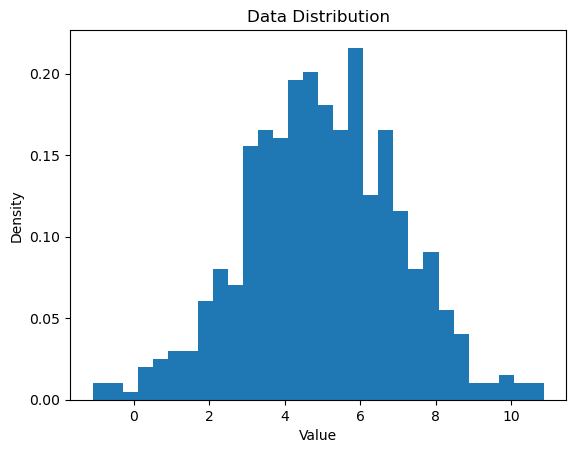

In [54]:
# データ生成 (例として1次元のガウス分布からのサンプル)
def generate_data(n_samples=500):
    return torch.randn(n_samples, 1) * 2 + 5

data = generate_data(500)
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# データの可視化
plt.hist(data.numpy(), bins=30, density=True)
plt.title("Data Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [55]:
# モデルとオプティマイザの初期化
input_dim = 1
hidden_dim = 128
time_embed_dim = 32
model = ScoreNet(input_dim, hidden_dim, time_embed_dim)
optimizer = Adam(model.parameters(), lr=1e-3)

epochs = 1000
for epoch in range(epochs):
    for batch in dataloader:
        x_0 = batch[0]
        t = torch.randint(0, timesteps, (x_0.shape[0],))
        loss = loss_fn(model, x_0, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.5777
Epoch [200/1000], Loss: 0.5608
Epoch [300/1000], Loss: 0.3574
Epoch [400/1000], Loss: 0.5062
Epoch [500/1000], Loss: 0.6197
Epoch [600/1000], Loss: 0.3088
Epoch [700/1000], Loss: 0.2499
Epoch [800/1000], Loss: 0.4758
Epoch [900/1000], Loss: 0.5207
Epoch [1000/1000], Loss: 0.3165


In [56]:
@torch.no_grad()
def sample(model, n_samples, device="cpu"):
    x_t = torch.randn(n_samples, input_dim).to(device)
    for i in reversed(range(timesteps)):
        t = torch.ones(n_samples, dtype=torch.long).to(device) * i
        sqrt_alpha_t = torch.sqrt(alphas[i])
        beta_t = betas[i]
        score_t = model(x_t, t)
        # 簡易的な逆拡散ステップ (より正確には確率微分方程式の離散化が必要)
        x_t = (1 / sqrt_alpha_t) * (x_t - (beta_t / torch.sqrt(1 - alpha_cumprod[i])) * score_t)
        if i > 0:
            noise = torch.randn_like(x_t)
            posterior_variance = beta_t
            x_t = x_t + torch.sqrt(posterior_variance) * noise
    return x_t.cpu().numpy()

# サンプリングの実行と結果の可視化
model.eval()
sampled_data = sample(model, n_samples=10000)

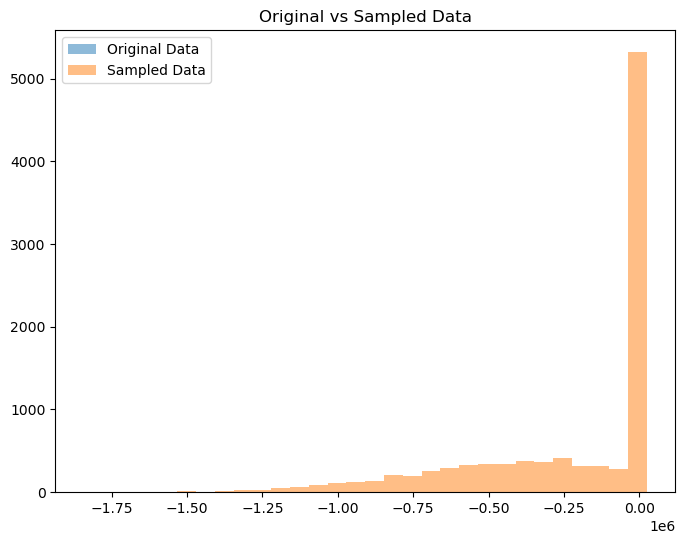

In [57]:
plt.figure(figsize=(8, 6))
plt.hist(data.numpy(), bins=30, alpha=0.5, label='Original Data')
plt.hist(sampled_data, bins=30, alpha=0.5, label='Sampled Data')
plt.legend()
plt.title('Original vs Sampled Data')
plt.show()